In [30]:
# Mesa is the primary package used for ABM
!pip install mesa
# Used for plotting
!pip install matplotlib

ERROR: Could not find a version that satisfies the requirement Qt5Agg (from versions: none)
ERROR: No matching distribution found for Qt5Agg


In [43]:
import math
import random
from mesa import Agent, Model
from mesa.space import NetworkGrid
from mesa.time import RandomActivation
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import collections
import csv

class MyAgent(Agent):
    """
    Specifying the agents in the network. They have the following parameters:
    - A static opinion on a given topic, either 0 (for negative) or 1 (for positive)
    - A static willigness to self censor. As there are individual differences in people's willingness to speak out, the given agent's willingness is drawn from a uniform distribution of [0: 1]
    - Confidence is the only variable that changes throughout the iterations. The initial confidence is also drawn from a uniform distribution [0: 1]
    - Previous_speak_out is used for updating the confidence of the agents later.
    """
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.opinion = random.choice([0, 1])
        self.willingness_to_self_censor = random.uniform(0, 1)
        self.confidence = random.uniform(0, 1)
        self.previous_speaks_out = False

        
    # LÆG MÆRKE TIL LEARNING RATE FORNEDEN (DEN AGERER LIDT EN PLACEHOLDER FOR ROUGHNESS OF THE NETWORK ELLER HVAD VI NU FINDER PÅ)
    def calculate_confidence(self, learning_rate=1.0):
        """Calculate the agent's confidence level based on the opinions of its neighbours."""
        # first the verbal neighbors are listed based on if they spoke out in the last iteration
        speaking_neighbors = [self.model.schedule.agents[neighbor_id] 
                              for neighbor_id in self.model.grid.G.neighbors(self.unique_id)
                              if self.model.schedule.agents[neighbor_id].previous_speaks_out]   
        
        # then the number of neighbouring agents with same or opposite opinions are summed.
        same_opinion = sum(1 for neighbor in speaking_neighbors if neighbor.opinion == self.opinion)
        opposite_opinion = sum(1 for neighbor in speaking_neighbors if neighbor.opinion != self.opinion)

        # and used to calculate the opinion climate
        opinion_climate = (same_opinion - opposite_opinion) / (same_opinion + opposite_opinion) if same_opinion + opposite_opinion > 0 else 0

        # FORLÆGELSE AF LEARNING RATE
        scaled_learning_rate = learning_rate * (1 - self.confidence)
        delta = scaled_learning_rate * (opinion_climate - self.confidence)

        # A sigmoid function is then applied to limit the confidence from into the interval of ]∞; 1] into [0; 1] - VI SKAL LIGE DOBBELTJEKKE AT DEN OGSÅ HAR EN UPPER LIMIT TIL 1
        self.confidence = 1 / (1 + math.exp(-(self.confidence + delta)))

        return self.confidence

    def decide_to_speak(self):
        # Check if the agent has a confidence higher than their willigness to self censor
        return self.confidence > self.willingness_to_self_censor

    def step(self):
        # updating the speak-out status of the agent
        self.previous_speaks_out = self.decide_to_speak()

class MyModel(Model):
    def __init__(self, N, m, y, ticks, make_plot=False):
        """
    Specifying the network. It has the following parameters:
    - The number of agents (N)
    - Number of edges to attach from a new node to existing nodes (m) in the Barabasi-Albert scale-free model
    - Degree distribution of the network (y). Usually lies between 2.5 to 3.0 according to our "main" study
    - Ticks are the number of maximum iterations that the model is allowed to take
    - Make plot is to trigger whether or not the model should make plots
    - Schedule is how the agents interact doing each iteration. In this case, we are using random activation.
    - History is for the generation of the CSV-file
    - Position is necessary for the generation of plots
    
        """
        self.num_agents = N
        self.m = m
        self.y = y
        self.ticks = ticks
        self.make_plot = make_plot
        self.schedule = RandomActivation(self)
        self.history = defaultdict(list)
        self.pos = None
        self.create_network()
        self.create_agents()

        # Create a Barabasi-Albert scale-free network
    def create_network(self):
        self.G = nx.barabasi_albert_graph(self.num_agents, self.m)
        self.grid = NetworkGrid(self.G)
        # deciding the edges based on the degree distribution of the network
        for edge in self.G.edges:
            self.G.edges[edge]['weight'] = self.y
        

    def create_agents(self):
        self.agent_dict = {}  # Create a dictionary to store agents
        for node in self.G.nodes:
            agent = MyAgent(node, self)  # using node as the agent's unique_id
            self.grid.place_agent(agent, node)
            self.schedule.add(agent)
            self.agent_dict[node] = agent  # Store agent in the dictionary

            # Creating a list to store values for the agents
            self.history = defaultdict(list)

    def draw_plot(self):
        if self.pos is None:
             self.pos = nx.spring_layout(self.grid.G)
        colors = []
        labels = {}
        for node in self.grid.G.nodes:
            agent = self.agent_dict[node]
            speaks_out = agent.decide_to_speak()
            if speaks_out:
                colors.append("green" if agent.opinion == 1 else "red")
                labels[node] = "+" if agent.opinion == 1 else "-"
            else:
                colors.append("white")
                labels[node] = ""

        plt.figure()
        nx.draw(self.grid.G, self.pos, node_color=colors, node_size=200, with_labels=False, alpha=0.6, width=0.5, edge_color="gray")
        nx.draw_networkx_labels(self.grid.G, self.pos, labels, font_size=12, font_color="black")
        nx.draw_networkx_nodes(self.grid.G, self.pos, node_color=colors, node_size=200, edgecolors="black", linewidths=1, alpha=0.7) 
        plt.title(f"Tick {self.schedule.steps}")
        plt.show()

    def step(self):
        stable_state = True
        stable_state = not any(abs(agent.confidence - agent.calculate_confidence()) >= 0.001
                                for agent in self.schedule.agents)

        if self.make_plot:
            self.draw_plot()
            
        self.schedule.step()

        # Update previous_speaks_out for each agent after the plot is drawn
        for agent in self.schedule.agents:
            agent.previous_speaks_out = agent.decide_to_speak()
        return stable_state
        
    def run(self):
        stable_ticks = 0
        for t in range(self.ticks):
            stable = self.step()
            if stable:
                stable_ticks += 1
            else:
                stable_ticks = 0  # Reset the count if the state is not stable

            if stable_ticks >= 10:  # Require the state to be stable for 10 consecutive ticks
                self.ticks_to_stability = t
                break

        # Find the node with the highest degree centrality
        central_node = max(nx.degree_centrality(self.G), key=nx.degree_centrality(self.G).get)
        # Get the opinion of the most central node
        self.central_node_opinion = self.schedule.agents[central_node].opinion

        # Define categories
        categories = {
            'Opinion 0 Speak Out': 0,
            'Opinion 1 Speak Out': 0,
            'Silent Agents': 0
        }
        for agent in self.schedule.agents:
            agent_history = (agent.opinion, agent.previous_speaks_out)
            if agent_history in [(0, True), (1, True)]:
                category = 'Opinion {} Speak Out'.format(agent.opinion)
            else:
                category = 'Silent Agents'
            categories[category] += 1
            self.history[agent.unique_id].append(agent_history)

        self.majority_opinion = 0 if categories['Opinion 0 Speak Out'] > categories['Opinion 1 Speak Out'] else 1
        self.categories = categories  # Save categories to the model instance

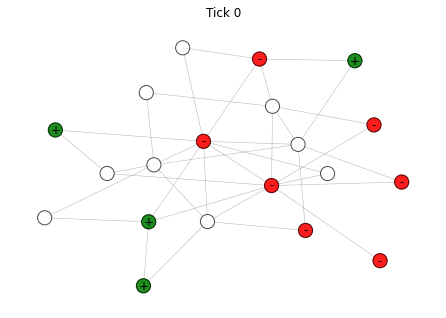

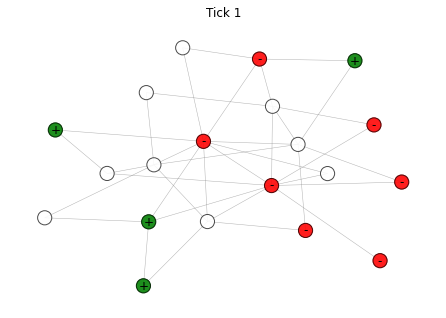

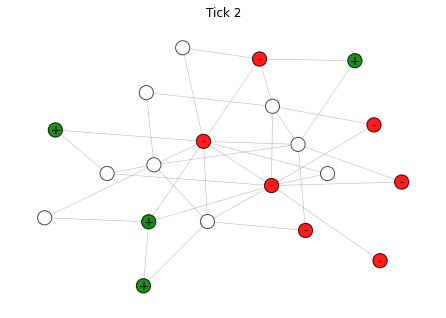

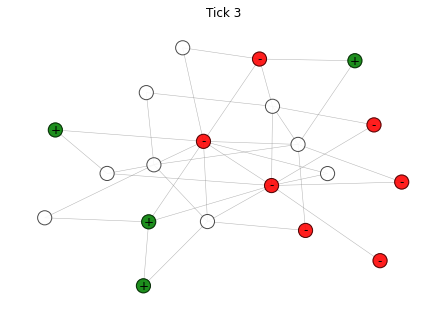

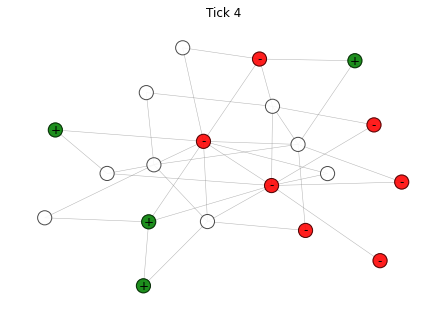

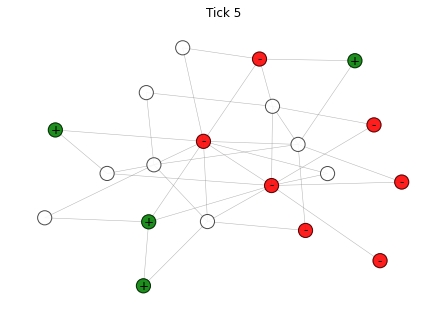

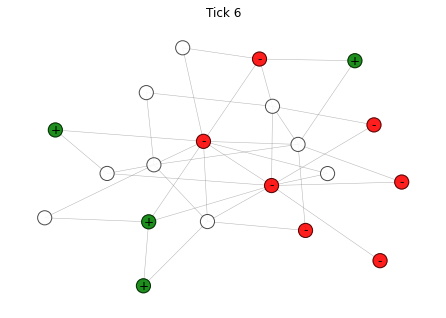

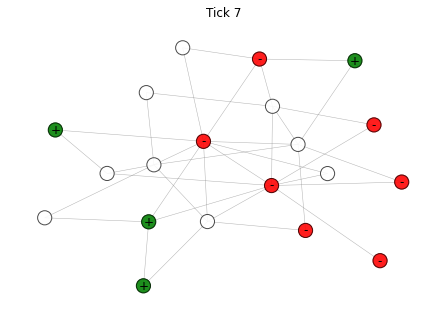

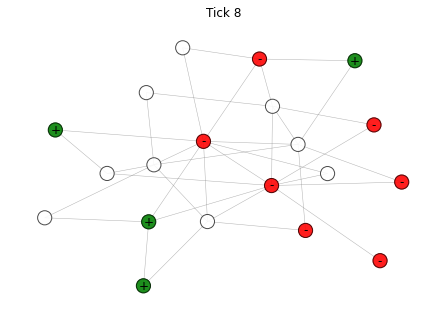

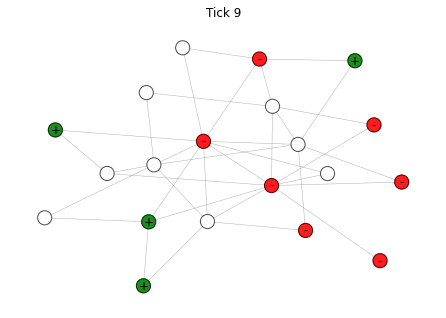

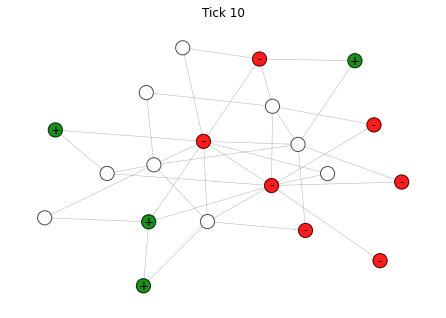

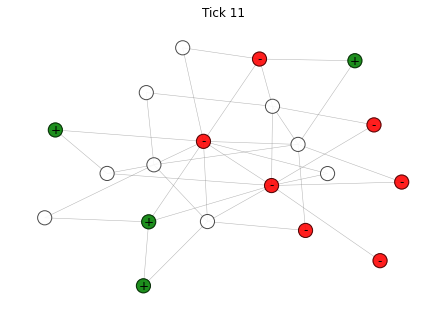

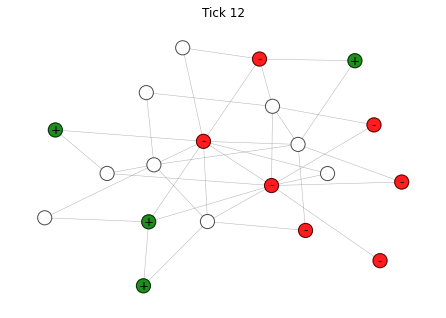

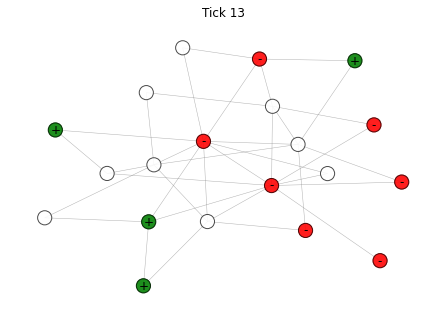

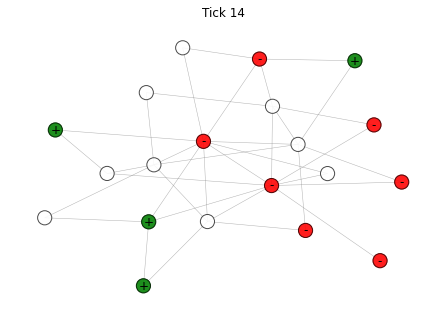

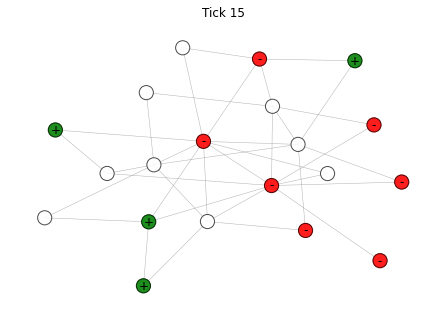

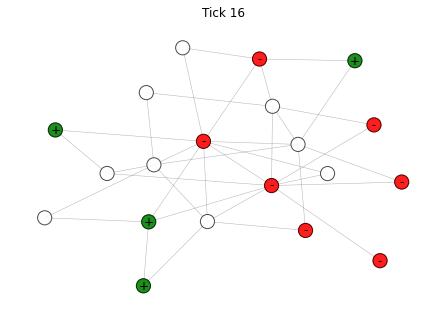

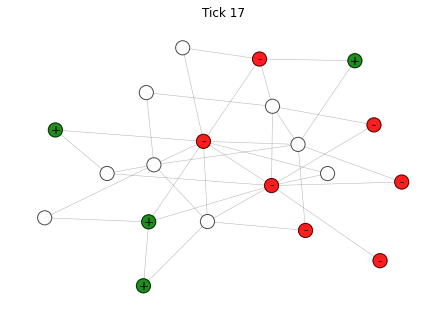

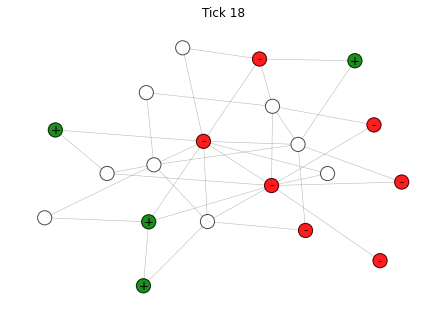

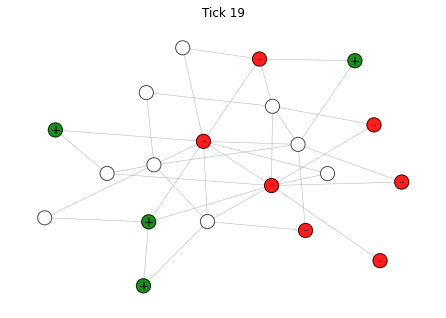

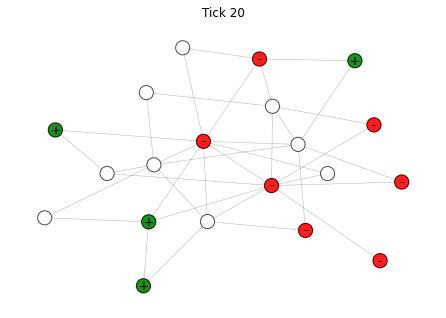

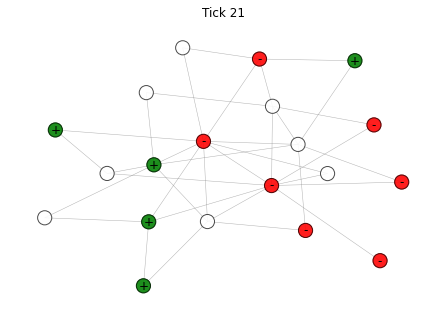

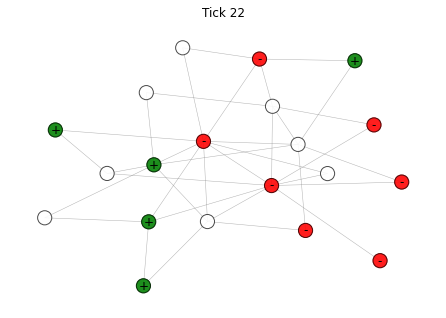

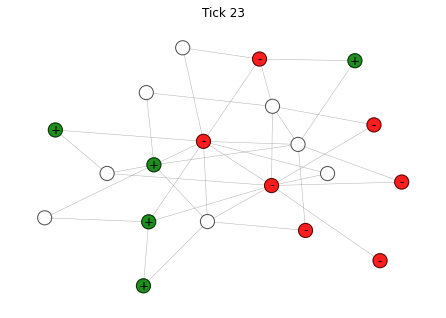

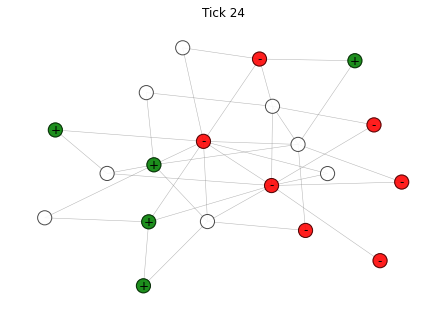

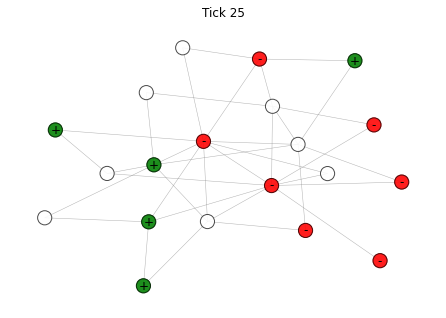

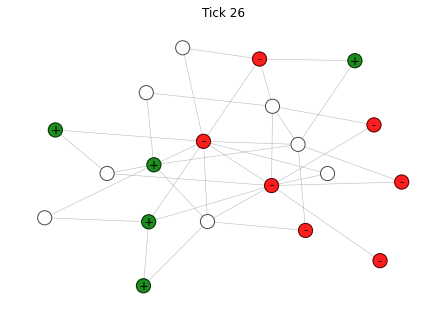

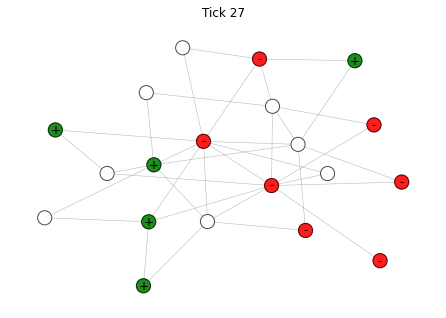

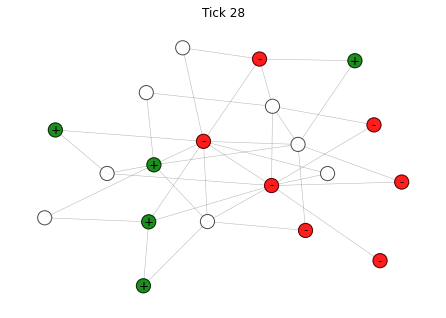

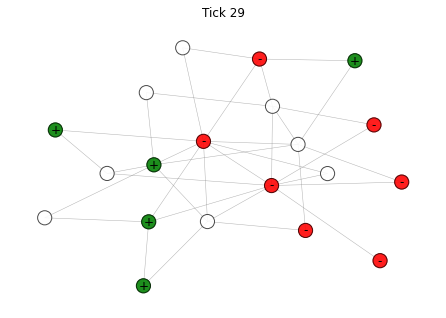

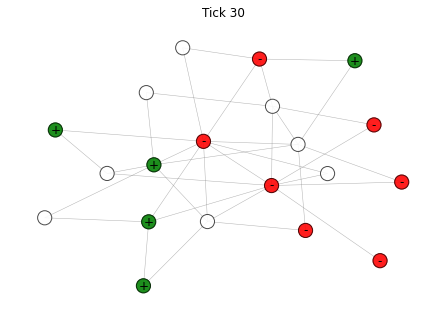

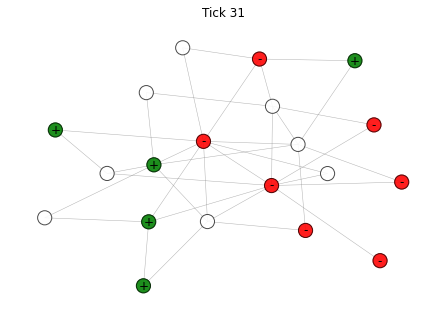

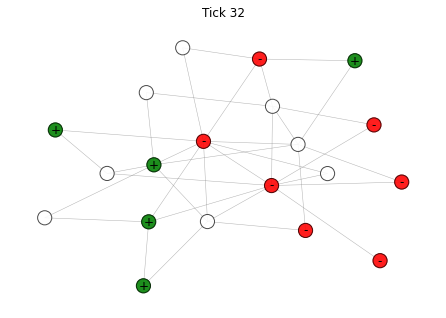

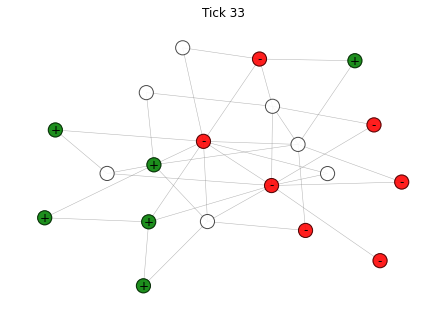

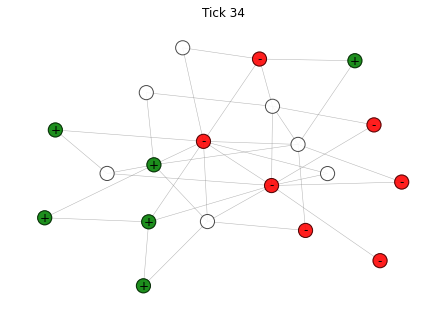

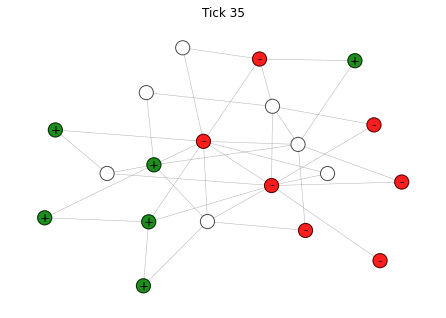

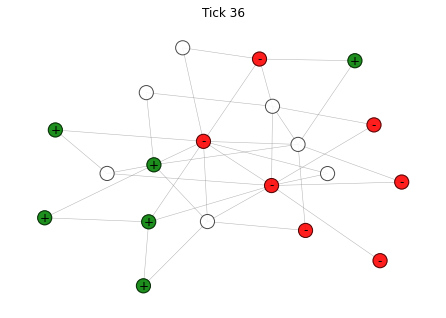

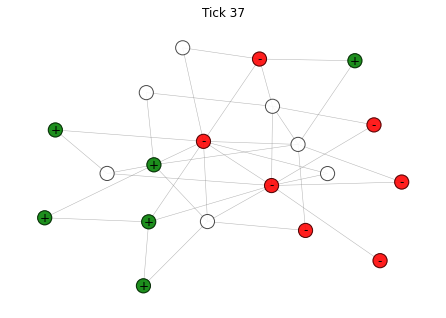

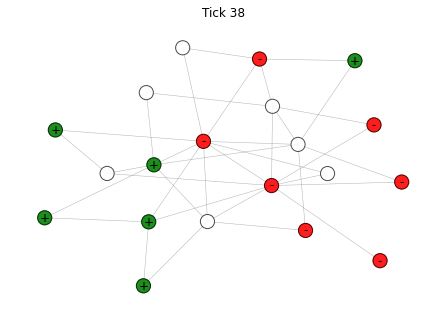

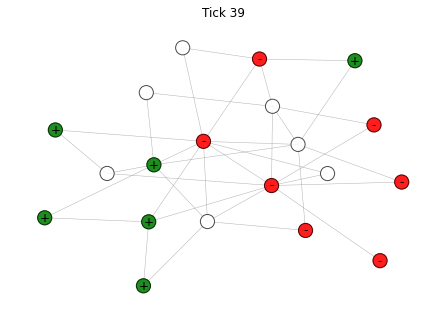

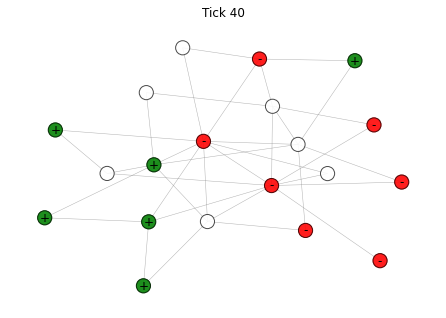

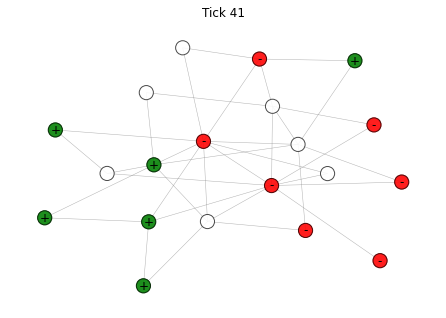

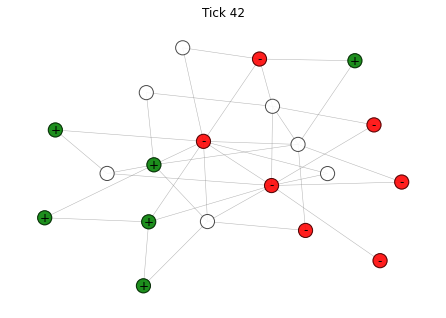

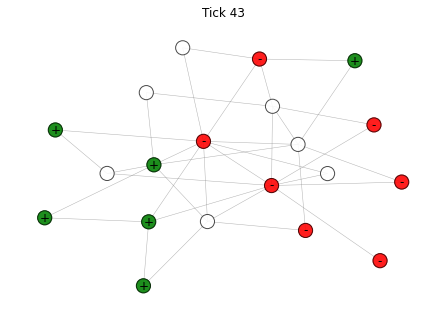

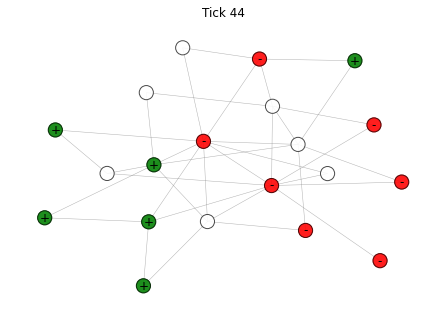

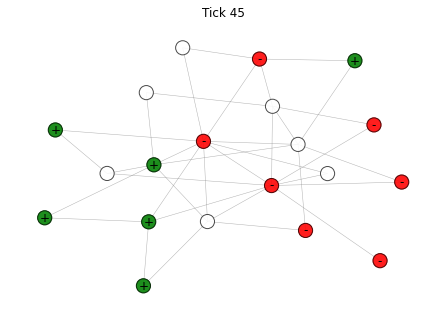

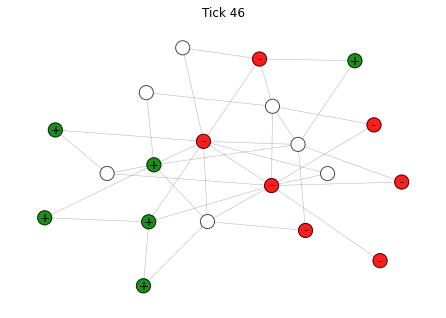

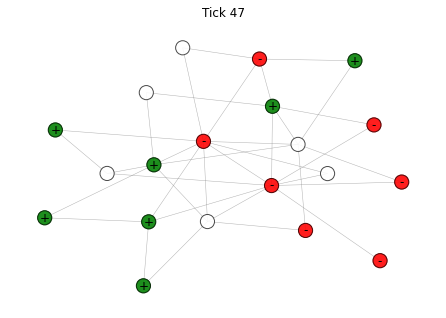

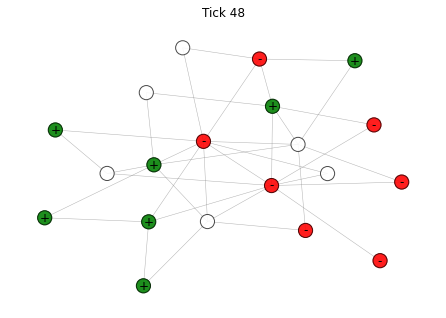

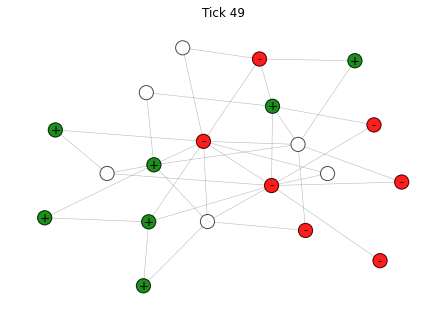

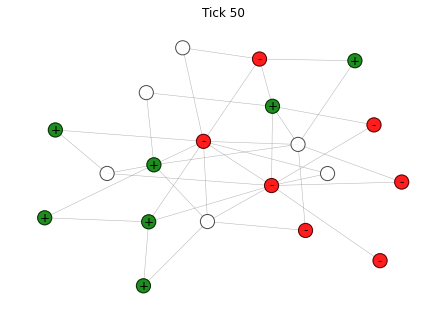

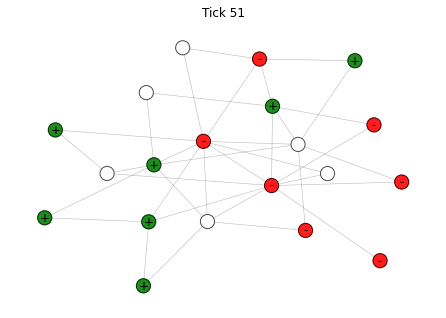

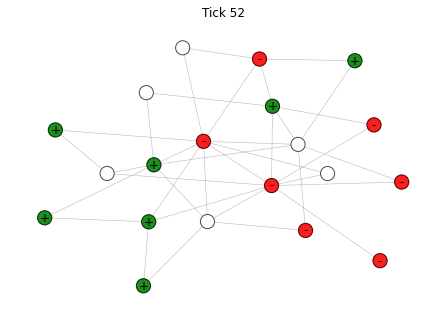

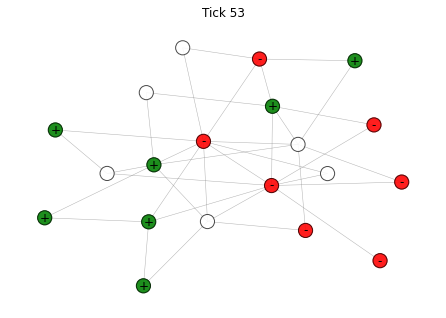

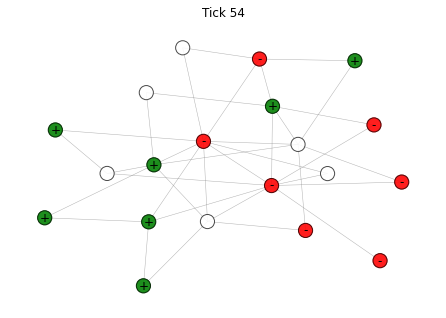

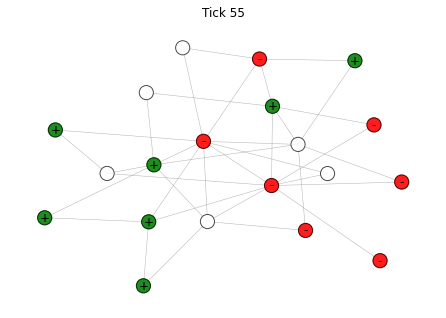

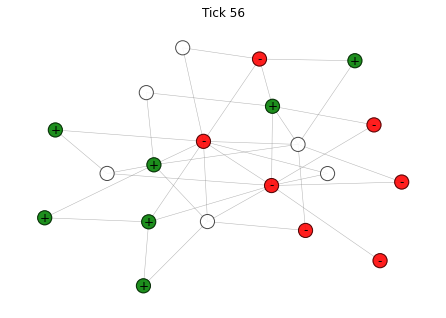

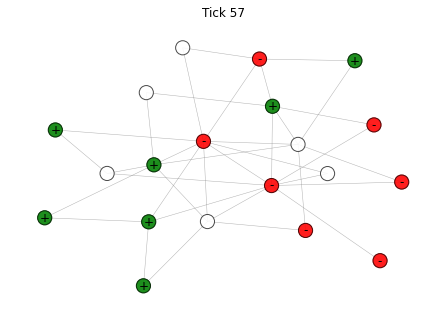

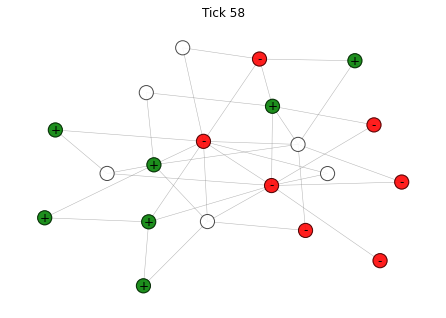

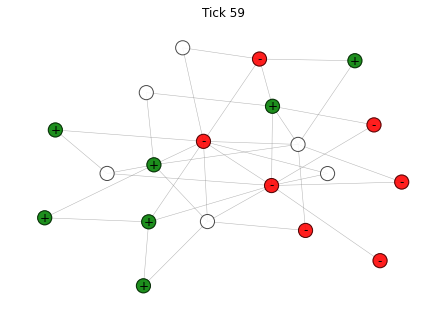

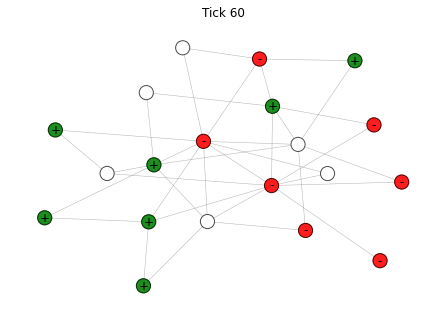

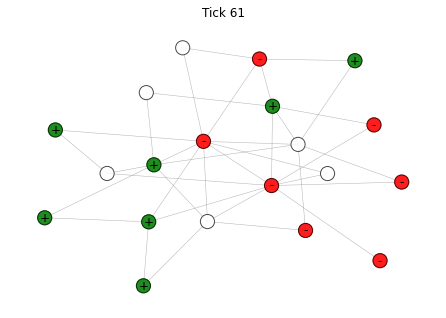

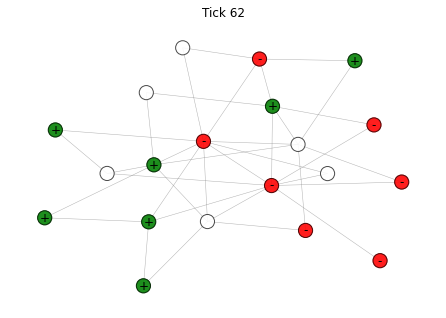

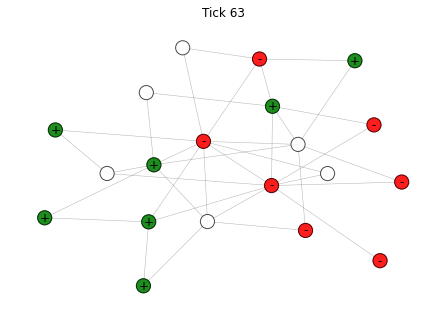

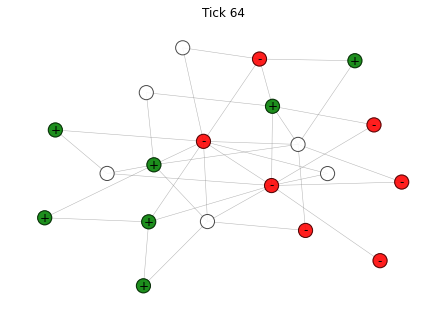

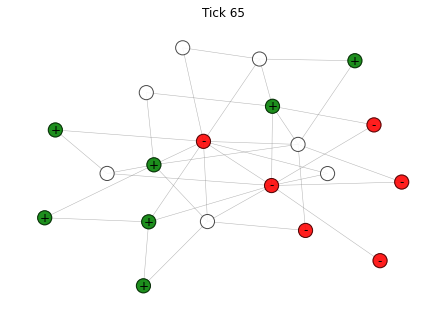

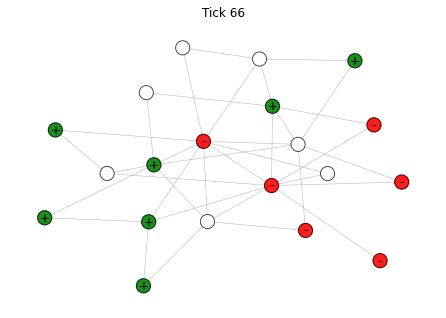

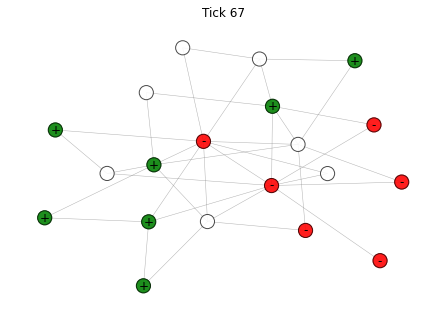

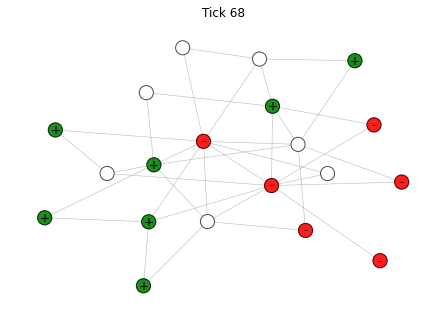

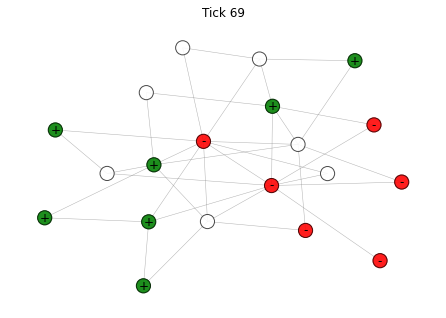

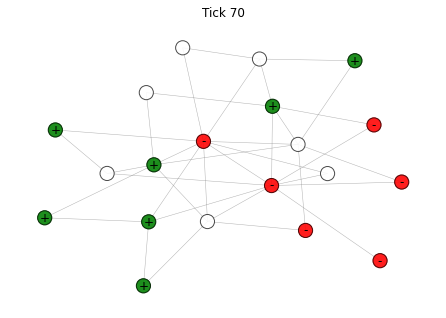

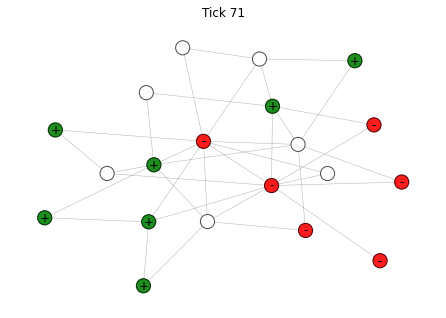

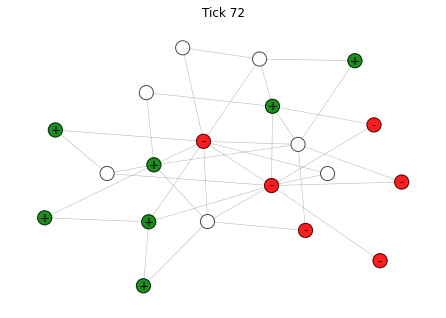

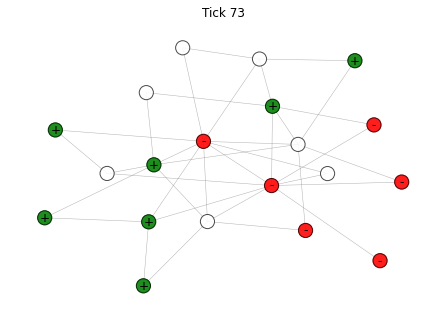

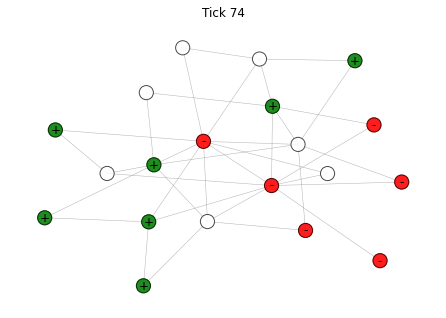

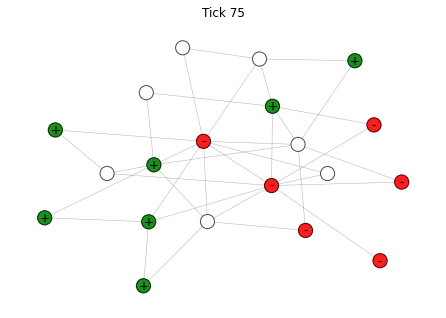

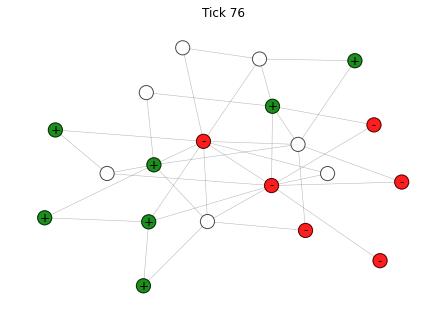

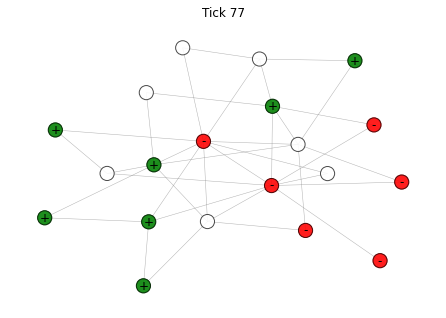

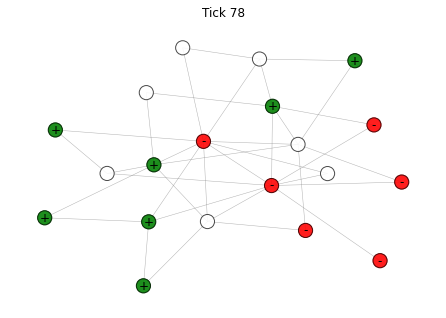

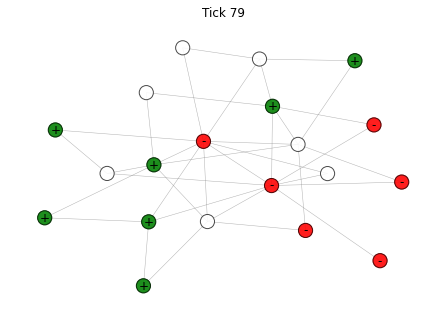

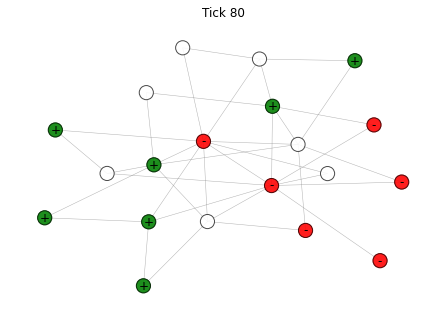

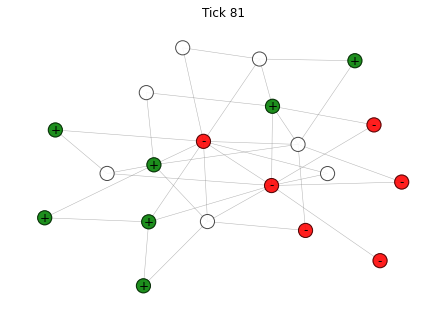

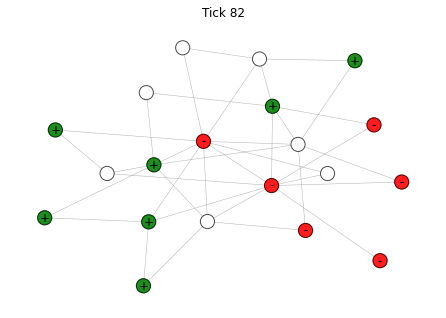

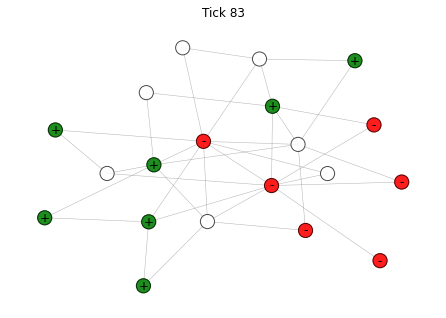

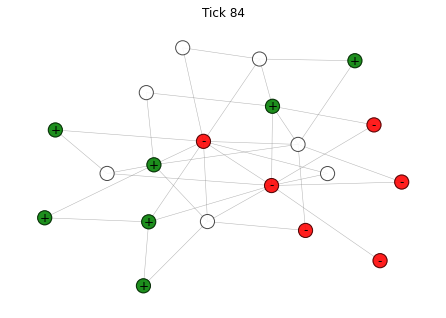

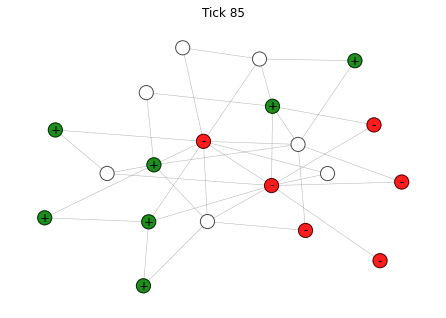

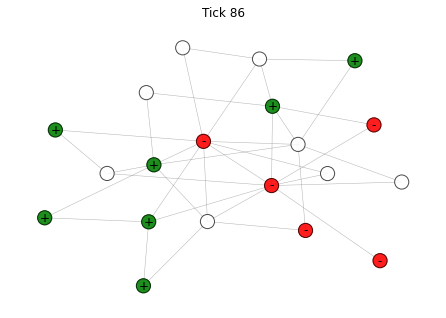

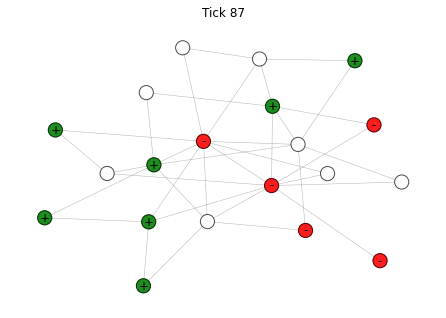

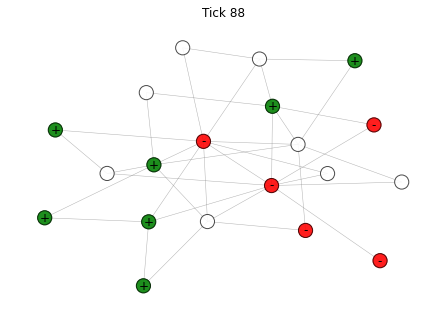

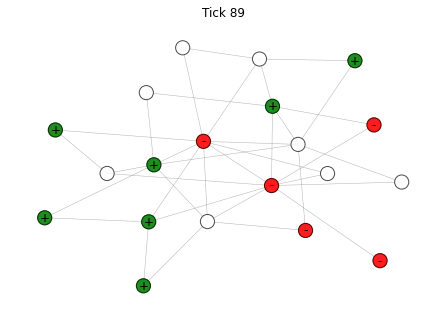

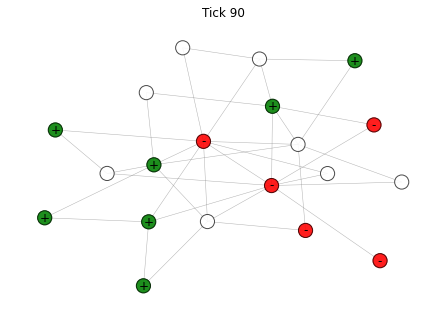

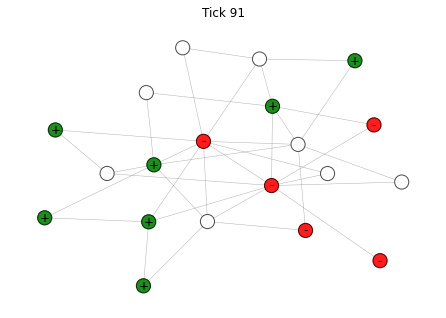

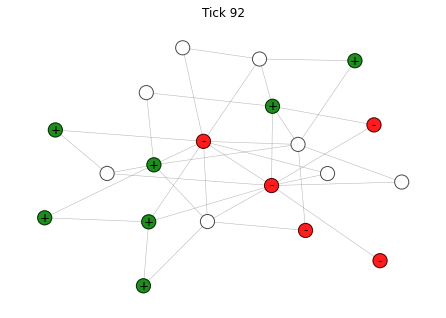

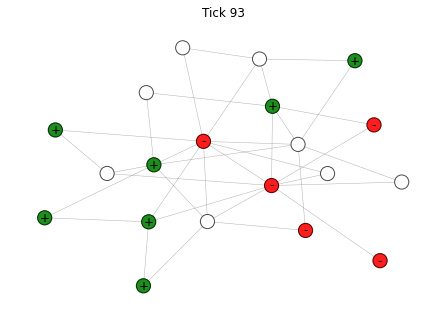

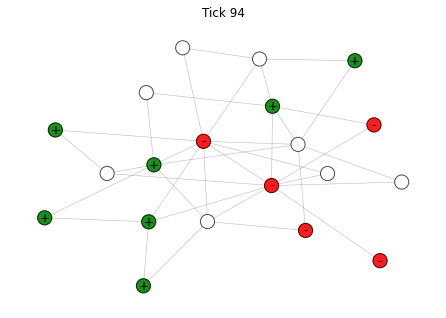

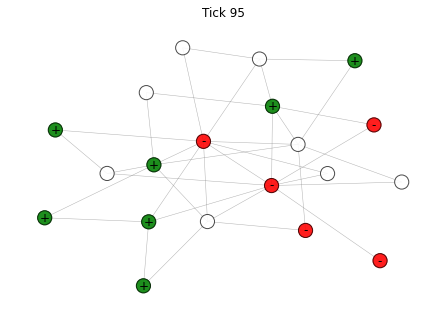

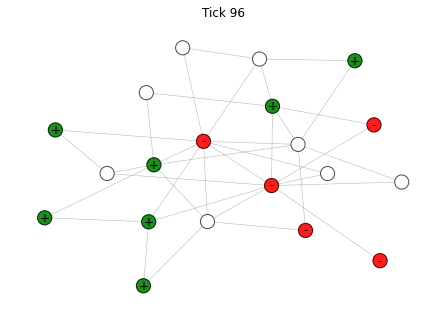

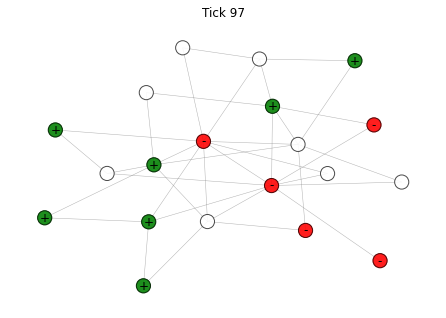

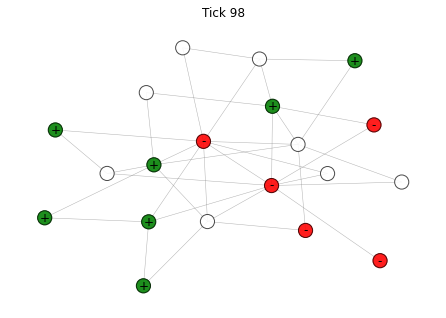

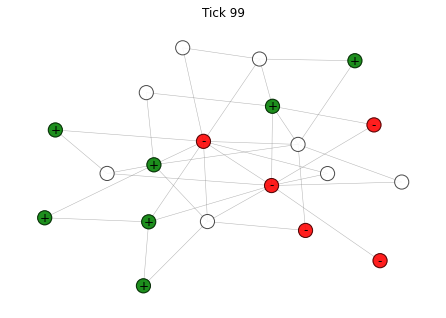

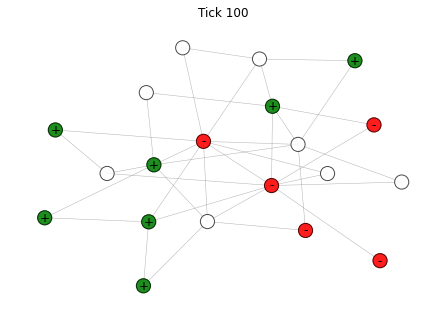

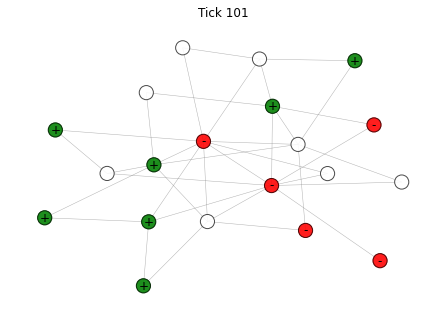

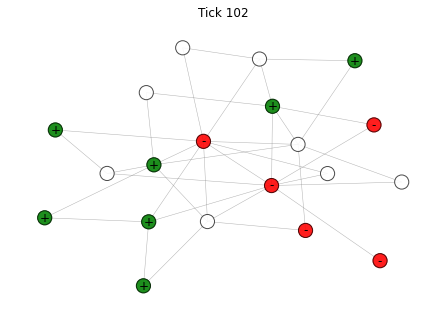

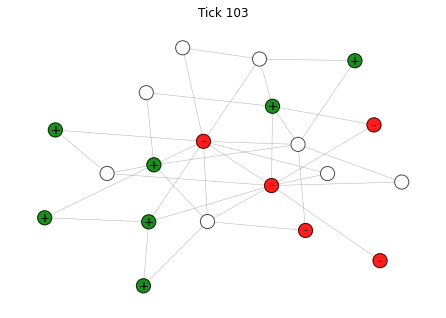

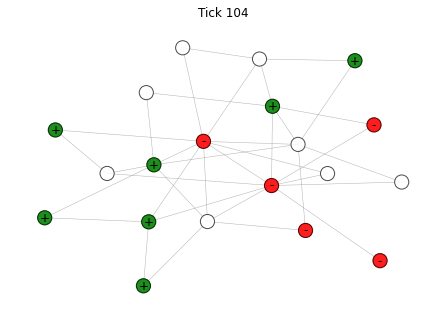

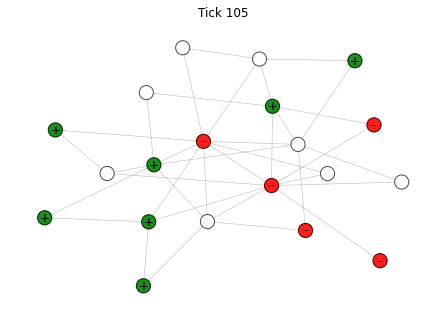

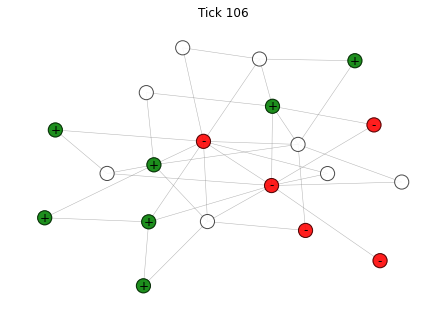

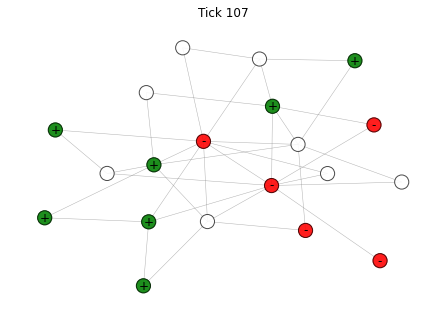

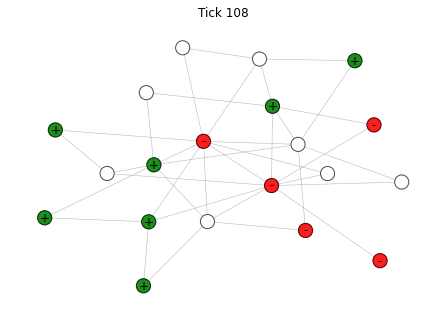

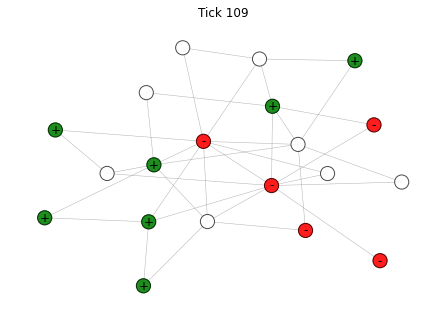

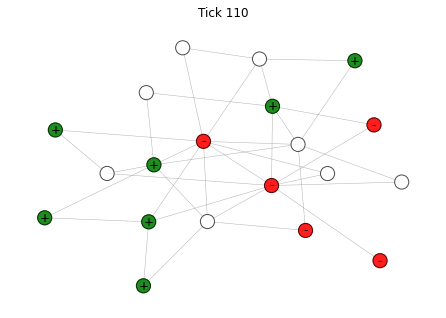

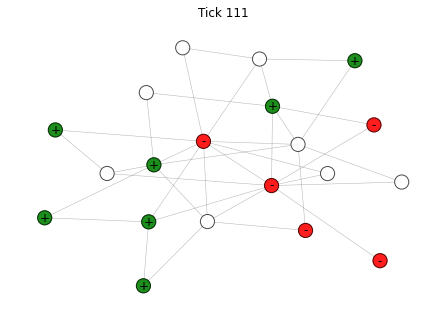

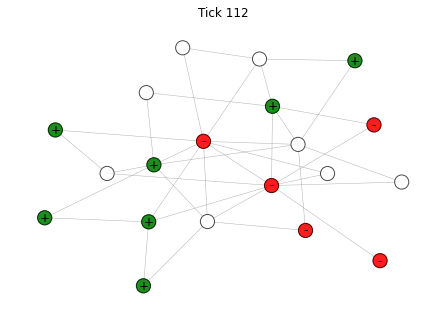

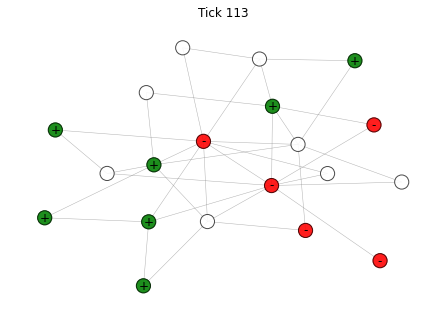

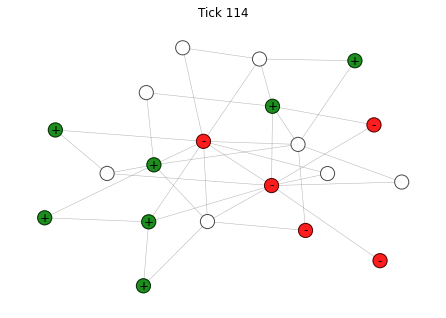

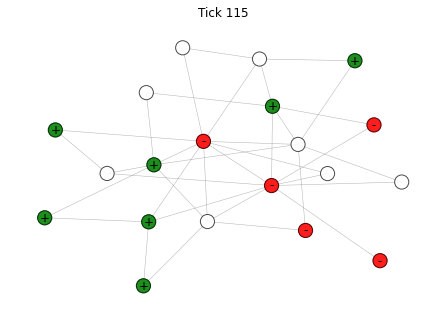

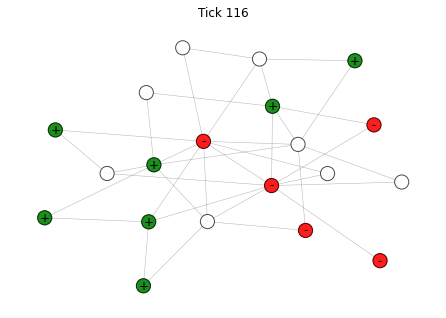

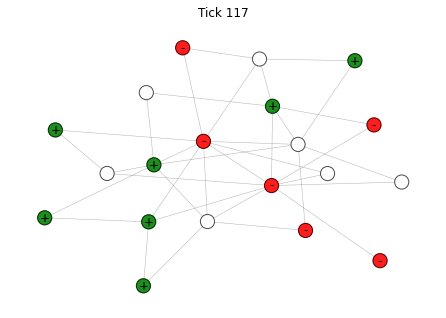

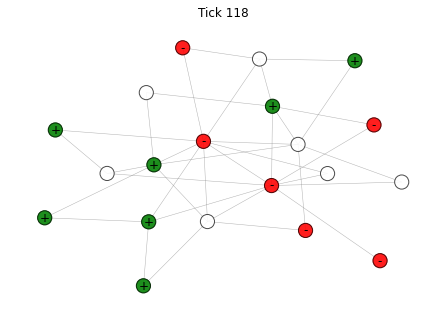

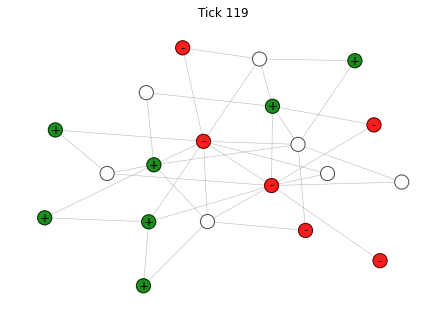

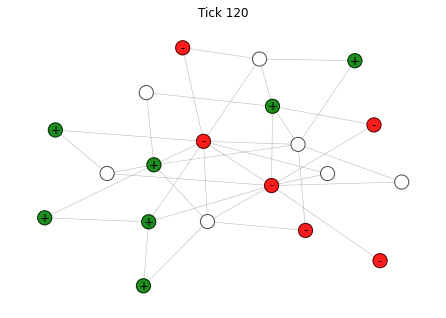

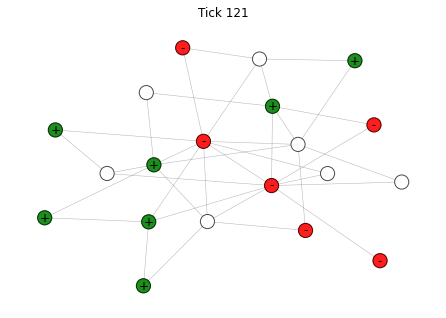

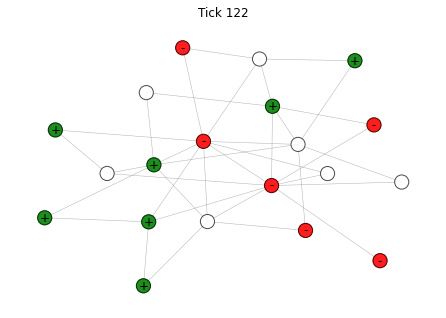

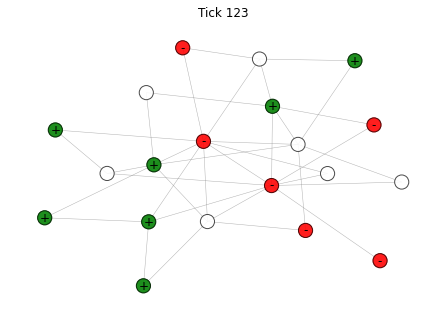

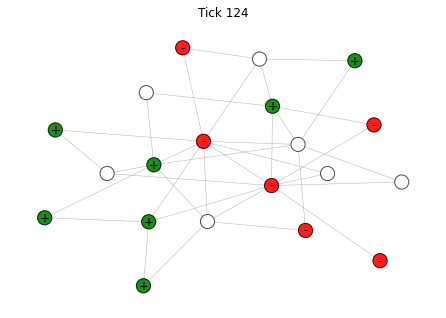

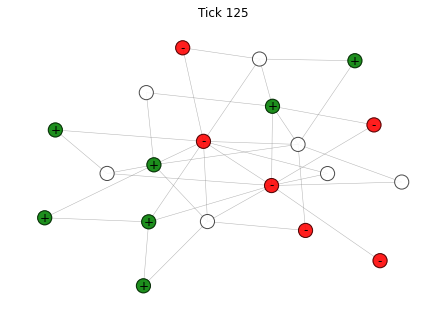

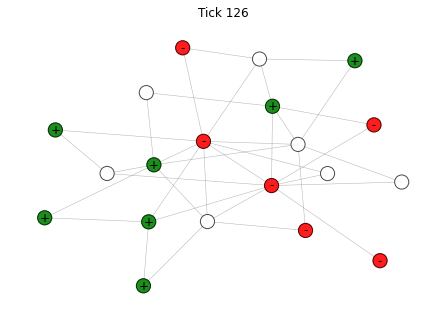

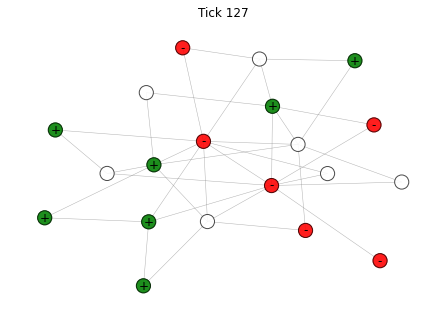

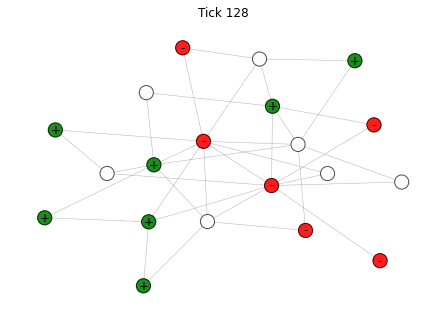

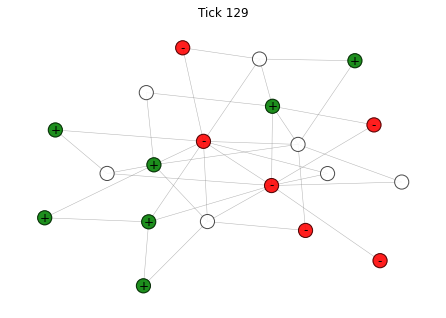

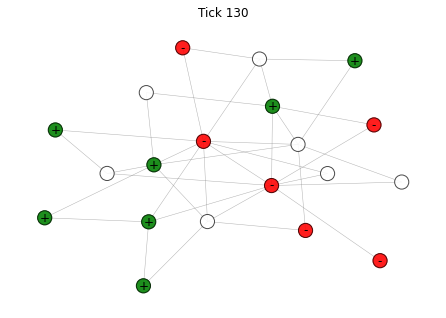

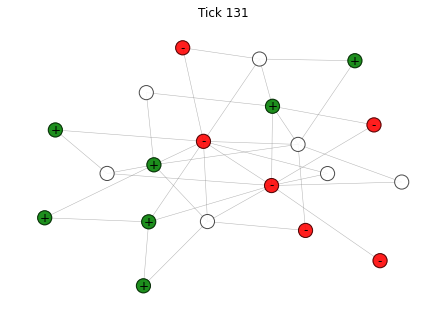

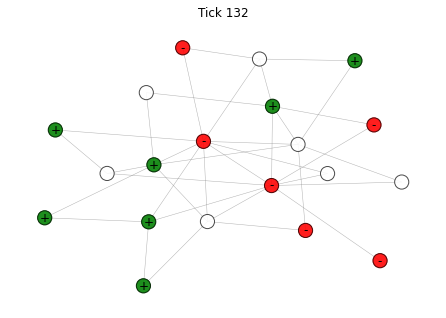

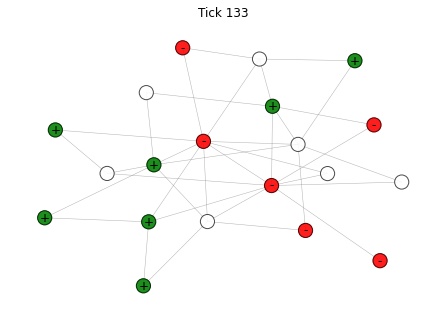

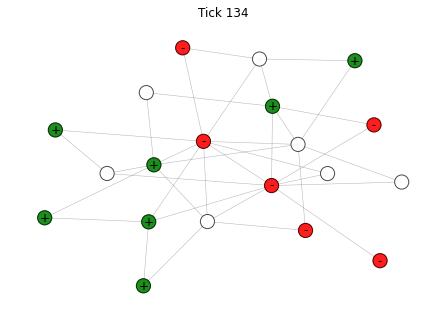

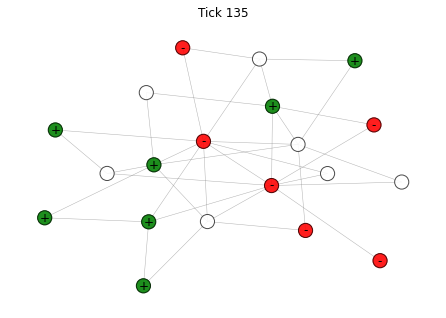

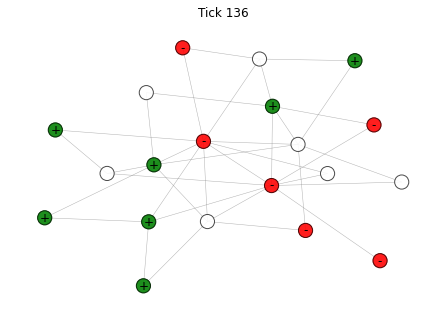

In [44]:
# Define the parameters. For single simulation
N = 20
m = 2
y = 2.5
ticks = 2000

model = MyModel(N, m, y, ticks, make_plot= True)
model.run()

In [45]:
# For multiple simulation
N = 20
y = 2.5
ticks = 2000
m_values = range(1, 11)
num_simulations = 10
 
# Create a dictionary to store the results for each m value
results = {m: [] for m in m_values}

# Run the simulations
for m in m_values:
    for _ in range(num_simulations):
        model = MyModel(N, m, y, ticks, make_plot= False)
        model.run()
        results[m].append(model.history)

# Define the categories
categories = ['Opinion 0 Speak Out', 'Opinion 1 Speak Out', 'Silent Agents']

# Write the results to a CSV file
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    # Write the header
    writer.writerow(['m', 'N', 'Simulation'] + categories + ['Opinion 0 Percentage', 'Opinion 1 Percentage', 'Silent Agents Percentage', 'Majority Opinion', 'Central Node Opinion', 'Central Node Equals Majority', 'Ticks to Stability'])
    # Write the results for each simulation
    for m, simulations in results.items():
        for i, simulation in enumerate(simulations, 1):
            counts = collections.defaultdict(int)
            for agent_history in simulation.values():
                opinion, speaks_out = agent_history[-1]
                if speaks_out:
                    category = 'Opinion {} Speak Out'.format(opinion)
                else:
                    category = 'Silent Agents'
                counts[category] += 1
            counts_list = [counts[category] for category in categories]

            # Get the percentage for each category
            percentages = [count / N * 100 for count in counts_list]

            # Determine the majority opinion
            majority_opinion = 0 if counts['Opinion 0 Speak Out'] > counts['Opinion 1 Speak Out'] else 1

            # Get the central node's opinion and whether it equals the majority opinion
            central_node_opinion = model.central_node_opinion
            central_node_equals_majority = int(central_node_opinion == majority_opinion)

            # Get the number of ticks to stability
            ticks_to_stability = model.ticks_to_stability

            writer.writerow([m, N, i] + counts_list + percentages + [majority_opinion, central_node_opinion, central_node_equals_majority, ticks_to_stability])